In [1]:
import pandas as pd
import numpy as np

# 한글 폰트 깨짐 방지
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

#에러 무시
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import scale, minmax_scale, robust_scale

import xgboost as xgb

import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
# 속도와 각도 선형관계 있는 공식 찾기
# 찾은 후, 그 수치가 일정 수준 넘어가면 배럴이라는 것을 정의해야 함

In [3]:
hts = pd.read_csv('hts.csv', encoding = 'CP949')

In [4]:
# 번트는 팀 직전 타구이기 때문에 삭제

hts = hts.loc[(hts['타격결과'] != '번트안타')&
       (hts['타격결과'] != '번트아웃')&
       (hts['타격결과'] != '희생번트')]
hts.reset_index(drop = True, inplace = True)

# 안타 여부 표시
hts['안타여부'] = 0
hts['장타여부'] = 0

# 안타가 된 타구만 1로 
hts['안타여부'][(hts['타격결과'] == '1루타')] = 1
hts['안타여부'][(hts['타격결과'] == '2루타')] = 1
hts['안타여부'][(hts['타격결과'] == '3루타')] = 1
hts['안타여부'][(hts['타격결과'] == '홈런')] = 1
hts['안타여부'][(hts['타격결과'] == '직선타')] = 1 # 직선타를 안타로 설정

# 장타가 된 타구
hts['장타여부'][(hts['타격결과'] == '1루타')] = 1
hts['안타여부'][(hts['타격결과'] == '내야안타(1루타)')] = 1
hts['장타여부'][(hts['타격결과'] == '2루타')] = 2
hts['장타여부'][(hts['타격결과'] == '3루타')] = 3
hts['장타여부'][(hts['타격결과'] == '홈런')] = 4

In [5]:
hts = hts[['경기코드', '선수코드', '이닝', '타구속도', '발사각도', '타격결과', '안타여부', '장타여부']]

In [6]:
# 이상치 제거
# 함수 정의
def outlier(df, column):   
    
    Q1 = np.quantile(df[column], 0.25)
    Q3 = np.quantile(df[column], 0.75)   
    IQR = Q3 - Q1               
    minimum = Q1 - (IQR * 1.5)
    maximum = Q3 + (IQR * 1.5)
    print('---------', column, '의 이상치---------')
    print('IQR :',IQR)     
    print('minimum :', minimum)     
    print('maximum :', maximum)
    
    NumOfOutlier = df[(df[column] > maximum) | (df[column] < minimum)].shape[0]
    print('upper bound 이상치 개수 : ', df[df[column] > maximum].shape[0])
    print('lower bound 이상치 개수 : ', df[df[column] < minimum].shape[0])
    print('총 이상치 개수 : ', NumOfOutlier)

In [7]:
outlier(hts, '타구속도')

--------- 타구속도 의 이상치---------
IQR : 27.670000000000016
minimum : 80.34499999999997
maximum : 191.02500000000003
upper bound 이상치 개수 :  2
lower bound 이상치 개수 :  2137
총 이상치 개수 :  2139


In [8]:
outlier(hts, '발사각도')

--------- 발사각도 의 이상치---------
IQR : 33.6
minimum : -51.800000000000004
maximum : 82.60000000000001
upper bound 이상치 개수 :  610
lower bound 이상치 개수 :  25
총 이상치 개수 :  635


In [9]:
hts = hts[(hts['타구속도'] > 80.34499999999997) & (hts['타구속도'] < 191.02500000000003)]
hts = hts[(hts['발사각도'] > -51.800000000000004) & (hts['발사각도'] < 82.60000000000001)]

In [10]:
hts = hts.reset_index(drop = True)

In [11]:
hts

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1
...,...,...,...,...,...,...,...,...
117682,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0
117683,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1
117684,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4
117685,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4


In [12]:
# hts2 = hts

In [13]:
# 안타가 된 타구만 추출
hts_hit = hts.loc[(hts['안타여부'] == 1)]

# 안타가 되지 않은 타구 추출
hts_nonhit = hts.loc[(hts['안타여부'] == 0)]

In [14]:
hts_hit = hts_hit[['타구속도', '발사각도', '타격결과', '장타여부']]
hts_nonhit = hts_nonhit[['타구속도', '발사각도', '타격결과', '장타여부']]

In [15]:
hts_hit.reset_index(drop = True, inplace = True)
hts_nonhit.reset_index(drop = True, inplace = True)

In [16]:
hts_hit_except_single = hts_hit.loc[(hts_hit['타격결과'] == '2루타') |
           (hts_hit['타격결과'] == '3루타')|
#            (hts_hit['타격결과'] == '직선타') |
           (hts_hit['타격결과'] == '홈런')]

In [17]:
hts_hit_except_single['발사각도'].mean()

21.02284237726097

In [18]:
hts['발사각도'].min()

-50.2

In [19]:
hts_pasaeng = hts

In [20]:
hts_pasaeng['발사각도'] = hts_pasaeng['발사각도'] + 51.2
# hts_pasaeng['발사각도'] = hts_pasaeng['발사각도'] + 69.2

In [21]:
hts_pasaeng['발사각도'] = 100 - abs((21.02284237726097 + 51.2) - hts_pasaeng['발사각도'])
# hts_pasaeng['발사각도'] = 100 - abs((21.02284237726097 + 69.2) - hts_pasaeng['발사각도'])

In [22]:
hts_pasaeng.groupby('타격결과')['발사각도'].agg('mean').sort_values()

타격결과
파울플라이        54.439143
인필드플라이       56.309971
삼중살타         65.327158
야수선택         70.783824
땅볼아웃         71.536644
병살타          71.926959
내야안타(1루타)    73.927803
플라이          81.359380
1루타          85.191359
희생플라이        87.848240
직선타          88.269917
2루타          91.686495
홈런           92.046679
3루타          92.231953
Name: 발사각도, dtype: float64

In [23]:
df_num = hts_pasaeng[['타구속도', '발사각도']]

In [24]:
df_scale_minmax = minmax_scale(df_num)
df_scale_minmax = pd.DataFrame(df_scale_minmax, columns = df_num.columns)
df_scale_minmax

,타구속도,발사각도
0,0.488539,0.695866
1,0.523687,0.844101
2,0.688252,0.734551
3,0.318720,0.894663
4,0.778892,0.754213
...,...,...
117682,0.581471,0.636236
117683,0.198090,0.848956
117684,0.635053,0.826484
117685,0.628176,0.959911


In [25]:
hts_pasaeng['표준화_속도'] = df_scale_minmax['타구속도']
hts_pasaeng['표준화_각도'] = df_scale_minmax['발사각도']

In [26]:
hts_pasaeng['파생변수'] = hts_pasaeng['타구속도'] * hts_pasaeng['발사각도']
hts_pasaeng['표준화_파생변수'] = hts_pasaeng['표준화_속도'] + hts_pasaeng['표준화_각도']

In [27]:
hts_pasaeng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117687 entries, 0 to 117686
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   경기코드      117687 non-null  object 
 1   선수코드      117687 non-null  int64  
 2   이닝        117687 non-null  int64  
 3   타구속도      117687 non-null  float64
 4   발사각도      117687 non-null  float64
 5   타격결과      117687 non-null  object 
 6   안타여부      117687 non-null  int64  
 7   장타여부      117687 non-null  int64  
 8   표준화_속도    117687 non-null  float64
 9   표준화_각도    117687 non-null  float64
 10  파생변수      117687 non-null  float64
 11  표준화_파생변수  117687 non-null  float64
dtypes: float64(6), int64(4), object(2)
memory usage: 10.8+ MB


In [28]:
hts_pasaeng.groupby('타격결과')['파생변수'].agg('mean').sort_values()

타격결과
파울플라이         6364.135514
인필드플라이        6445.353172
야수선택          8877.085983
땅볼아웃          9387.415257
삼중살타          9651.731767
병살타           9669.626098
내야안타(1루타)     9741.163449
플라이          10820.743427
1루타          11745.173724
희생플라이        12157.279914
직선타          12247.672673
2루타          13499.601396
3루타          13549.950603
홈런           14303.240020
Name: 파생변수, dtype: float64

In [29]:
hts_pasaeng.groupby('타격결과')['표준화_파생변수'].agg('mean').sort_values()

타격결과
파울플라이        0.703743
인필드플라이       0.721521
야수선택         1.010030
땅볼아웃         1.082918
병살타          1.120203
내야안타(1루타)    1.124069
삼중살타         1.156991
플라이          1.231936
1루타          1.347629
희생플라이        1.382895
직선타          1.394471
2루타          1.520521
3루타          1.527353
홈런           1.604240
Name: 표준화_파생변수, dtype: float64

<AxesSubplot:xlabel='타격결과', ylabel='표준화_파생변수'>

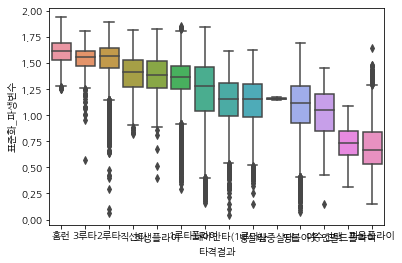

In [30]:
sns.boxplot(x = '타격결과',y = '표준화_파생변수', data=hts_pasaeng, order = ['홈런', '3루타', '2루타', '직선타', '희생플라이', 
                                                              '1루타', '플라이', '내야안타(1루타)', '병살타', '삼중살타',
                                                             '땅볼아웃', '야수선택', '인필드플라이', '파울플라이'])

In [31]:
hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,표준화_속도,표준화_각도,파생변수,표준화_파생변수
0,20180324HHWO0,62797,1,131.50,78.322842,플라이,0,0,0.488539,0.695866,10299.453773,1.184405
1,20180324HHWO0,76753,1,135.18,88.877158,1루타,1,1,0.523687,0.844101,12014.414167,1.367788
2,20180324HHWO0,71752,1,152.41,81.077158,1루타,1,1,0.688252,0.734551,12356.969593,1.422803
3,20180324HHWO0,62700,1,113.72,92.477158,1루타,1,1,0.318720,0.894663,10516.502365,1.213383
4,20180324HHWO0,78288,2,161.90,82.477158,1루타,1,1,0.778892,0.754213,13353.051819,1.533106
...,...,...,...,...,...,...,...,...,...,...,...,...
117682,20210711LTSS0,50458,8,141.23,74.077158,땅볼아웃,0,0,0.581471,0.636236,10461.916971,1.217707
117683,20210711LTSS0,62415,8,101.09,89.222842,1루타,1,1,0.198090,0.848956,9019.537136,1.047046
117684,20210711LTSS0,75566,8,146.84,87.622842,홈런,1,4,0.635053,0.826484,12866.538175,1.461537
117685,20210711LTSS0,69418,8,146.12,97.122842,홈런,1,4,0.628176,0.959911,14191.589728,1.588087


In [32]:
hts3 = pd.read_csv('hts.csv', encoding = 'CP949')

In [33]:
hts3

,연도,경기코드,타구코드,선수코드,타자 팀 코드,이닝,타구속도,발사각도,타격결과,투구구속,해당구장
0,2018,20180324HHWO0,180324_140436,62797,HH,1,131.50,42.7,플라이,149.59,고척
1,2018,20180324HHWO0,180324_140514,76753,HH,1,135.18,9.9,1루타,148.78,고척
2,2018,20180324HHWO0,180324_140647,71752,HH,1,152.41,2.1,1루타,148.59,고척
3,2018,20180324HHWO0,180324_140911,62700,HH,1,113.72,13.5,1루타,139.13,고척
4,2018,20180324HHWO0,180324_142050,68730,HH,2,54.11,16.4,번트안타,134.07,고척
...,...,...,...,...,...,...,...,...,...,...,...
120740,2021,20210711LTSS0,210711_195321,50458,SS,8,141.23,-4.9,땅볼아웃,137.76,대구
120741,2021,20210711LTSS0,210711_195424,62415,SS,8,101.09,31.8,1루타,138.51,대구
120742,2021,20210711LTSS0,210711_195627,75566,SS,8,146.84,33.4,홈런,134.10,대구
120743,2021,20210711LTSS0,210711_200047,69418,SS,8,146.12,23.9,홈런,139.96,대구


In [34]:
# 번트는 팀 직전 타구이기 때문에 삭제

hts3 = hts3.loc[(hts3['타격결과'] != '번트안타')&
       (hts3['타격결과'] != '번트아웃')&
       (hts3['타격결과'] != '희생번트')]
hts3.reset_index(drop = True, inplace = True)

# 안타 여부 표시
hts3['안타여부'] = 0
hts3['장타여부'] = 0

# 안타가 된 타구만 1로 
hts3['안타여부'][(hts3['타격결과'] == '1루타')] = 1
hts3['안타여부'][(hts3['타격결과'] == '2루타')] = 1
hts3['안타여부'][(hts3['타격결과'] == '3루타')] = 1
hts3['안타여부'][(hts3['타격결과'] == '홈런')] = 1
hts3['안타여부'][(hts3['타격결과'] == '직선타')] = 1 # 직선타를 안타로 설정

# 장타가 된 타구
hts3['장타여부'][(hts3['타격결과'] == '1루타')] = 1
hts['안타여부'][(hts['타격결과'] == '내야안타(1루타)')] = 1
hts3['장타여부'][(hts3['타격결과'] == '2루타')] = 2
hts3['장타여부'][(hts3['타격결과'] == '3루타')] = 3
hts3['장타여부'][(hts3['타격결과'] == '홈런')] = 4

hts3 = hts3[(hts3['타구속도'] > 80.34499999999997) & (hts3['타구속도'] < 191.02500000000003)]
hts3 = hts3[(hts3['발사각도'] > -51.800000000000004) & (hts3['발사각도'] < 82.60000000000001)]

hts3 = hts3.reset_index(drop = True)

In [35]:
hts3

,연도,경기코드,타구코드,선수코드,타자 팀 코드,이닝,타구속도,발사각도,타격결과,투구구속,해당구장,안타여부,장타여부
0,2018,20180324HHWO0,180324_140436,62797,HH,1,131.50,42.7,플라이,149.59,고척,0,0
1,2018,20180324HHWO0,180324_140514,76753,HH,1,135.18,9.9,1루타,148.78,고척,1,1
2,2018,20180324HHWO0,180324_140647,71752,HH,1,152.41,2.1,1루타,148.59,고척,1,1
3,2018,20180324HHWO0,180324_140911,62700,HH,1,113.72,13.5,1루타,139.13,고척,1,1
4,2018,20180324HHWO0,180324_142310,78288,HH,2,161.90,3.5,1루타,145.75,고척,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117682,2021,20210711LTSS0,210711_195321,50458,SS,8,141.23,-4.9,땅볼아웃,137.76,대구,0,0
117683,2021,20210711LTSS0,210711_195424,62415,SS,8,101.09,31.8,1루타,138.51,대구,1,1
117684,2021,20210711LTSS0,210711_195627,75566,SS,8,146.84,33.4,홈런,134.10,대구,1,4
117685,2021,20210711LTSS0,210711_200047,69418,SS,8,146.12,23.9,홈런,139.96,대구,1,4


In [36]:
hts_pasaeng['발사각도'] = hts3['발사각도']

# 100 - abs((21.02284237726097 + 51.2) - hts_pasaeng['발사각도'])

In [37]:
########### hts 파일 최종 완료

hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,표준화_속도,표준화_각도,파생변수,표준화_파생변수
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,0.488539,0.695866,10299.453773,1.184405
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,0.523687,0.844101,12014.414167,1.367788
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,0.688252,0.734551,12356.969593,1.422803
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,0.318720,0.894663,10516.502365,1.213383
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,0.778892,0.754213,13353.051819,1.533106
...,...,...,...,...,...,...,...,...,...,...,...,...
117682,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,0.581471,0.636236,10461.916971,1.217707
117683,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,0.198090,0.848956,9019.537136,1.047046
117684,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,0.635053,0.826484,12866.538175,1.461537
117685,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,0.628176,0.959911,14191.589728,1.588087


In [38]:
hts_pasaeng.describe()

,선수코드,이닝,타구속도,발사각도,안타여부,장타여부,표준화_속도,표준화_각도,파생변수,표준화_파생변수
count,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000,117687.000000
mean,69763.075828,4.932159,135.289066,17.268504,0.408218,0.564608,0.524728,0.726855,10962.305136,1.251584
std,7392.949823,2.585260,18.889840,23.308854,0.491506,0.949181,0.180419,0.187533,2576.117269,0.293001
min,50054.000000,1.000000,80.350000,-50.200000,0.000000,0.000000,0.000000,0.000000,2503.077788,0.042052
25%,63963.000000,3.000000,123.190000,-1.300000,0.000000,0.000000,0.409169,0.603933,9278.125050,1.080322
50%,69209.000000,5.000000,138.360000,14.500000,0.000000,0.000000,0.554059,0.750642,11217.562913,1.300199
75%,76313.000000,7.000000,149.790000,31.800000,1.000000,1.000000,0.663228,0.883427,12891.670267,1.468851
max,99810.000000,12.000000,185.050000,82.600000,1.000000,4.000000,1.000000,1.000000,17812.930174,1.934288


In [295]:
barrel_point = 1.61
# barrel_point = 1.251584

barrel1 = hts_pasaeng[(hts_pasaeng['표준화_파생변수'] > barrel_point)]
hts_pasaeng['배럴여부'] = 0

hts_pasaeng['배럴여부'][(hts_pasaeng['표준화_파생변수'] > barrel_point)] = 1

# hts['안타여부'][(hts['타격결과'] == '1루타')] = 1

In [296]:
hts_pasaeng['배럴여부'].sum()

9579

In [297]:
hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,0.488539,0.695866,10299.453773,1.184405,0
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,0.523687,0.844101,12014.414167,1.367788,0
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,0.688252,0.734551,12356.969593,1.422803,0
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,0.318720,0.894663,10516.502365,1.213383,0
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,0.778892,0.754213,13353.051819,1.533106,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117682,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,0.581471,0.636236,10461.916971,1.217707,0
117683,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,0.198090,0.848956,9019.537136,1.047046,0
117684,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,0.635053,0.826484,12866.538175,1.461537,0
117685,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,0.628176,0.959911,14191.589728,1.588087,0


In [298]:
# 18시즌 삼진 : 	10688
# 19시즌 삼진 : 9595
# 20시즌 삼진 : 9855
# 21시즌 삼진 : 6000(추정치)
# 합계
#10688+9595+9855+6000

# 전체 hts 117687개 중 barrel1의 row는 16924 : 약 14.38%
# 시즌 전체 삼진 36138개의 14.38% : 5196

In [299]:
hitter = pd.read_csv('타자 기본.csv', encoding = 'CP949')

In [300]:
# 안타
# barrel1['안타여부'].sum()/(len(barrel1['안타여부']) + (10688+9595+9855+6000)*len(barrel1)/len(hts))
# barrel1['안타여부'].sum()/hitter['타수'].sum()*(len(barrel1)/len(hts))

barrel1['안타여부'].sum() / (hitter['타수'].sum()*len(barrel1)/len(hts))

0.492988652406288

In [301]:
# 장타
barrel1['장타여부'].sum()/(hitter['타수'].sum()*len(barrel1)/len(hts))

1.1943582814153757

In [302]:
barrel1['타격결과'].value_counts()

2루타          2916
플라이          2389
홈런           2373
1루타          1229
직선타           354
3루타           170
희생플라이         141
땅볼아웃            4
병살타             1
파울플라이           1
내야안타(1루타)       1
Name: 타격결과, dtype: int64

<AxesSubplot:xlabel='타구속도', ylabel='발사각도'>

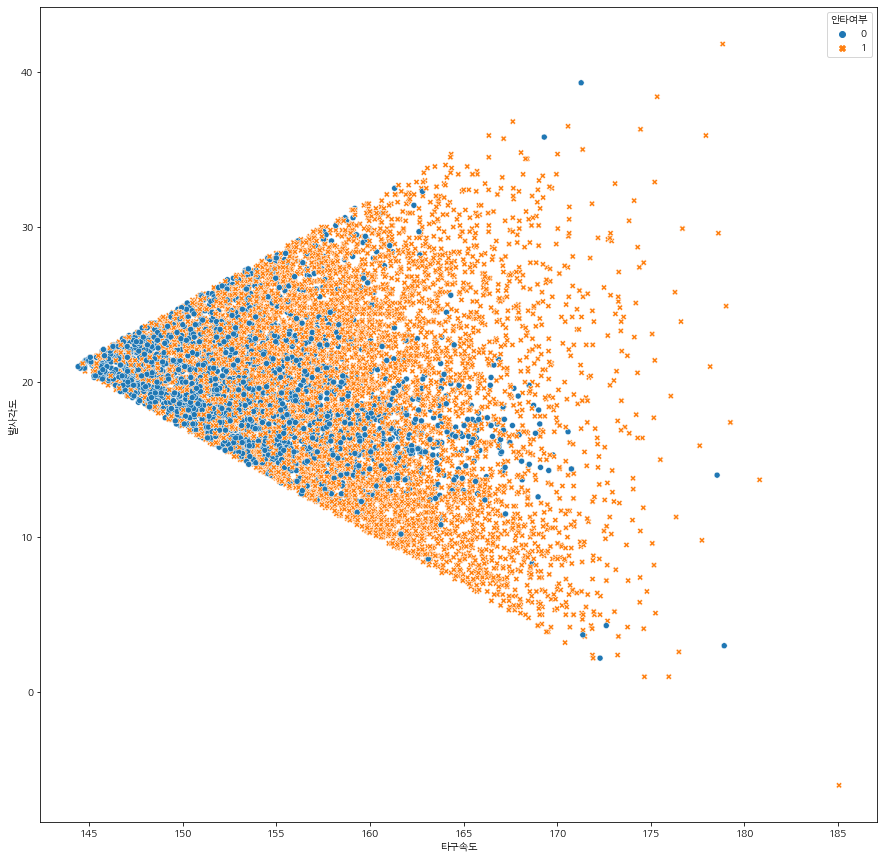

In [303]:
plt.subplots(figsize=(15, 15))
sns.scatterplot(x="타구속도", y="발사각도", hue = '안타여부', style = '안타여부', data=barrel1)

<AxesSubplot:xlabel='타구속도', ylabel='발사각도'>

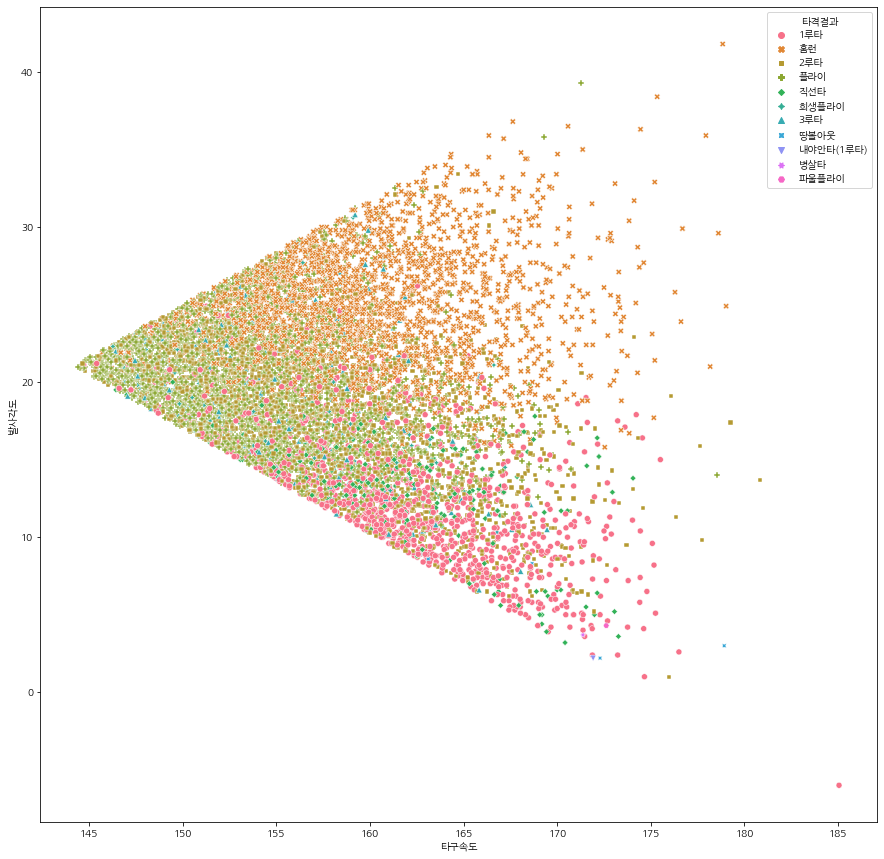

In [304]:
plt.subplots(figsize=(15, 15))
sns.scatterplot(x="타구속도", y="발사각도", hue = '타격결과', style = '타격결과', data=barrel1)

In [305]:
barrel1 = barrel1.reset_index(drop = True)

In [306]:
barrel1.loc[(barrel1['타격결과'] == '파울플라이')]

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
5402,20190908OBLG0,69165,1,172.62,4.3,파울플라이,0,0,0.88128,0.765449,14375.302949,1.646729,1


In [307]:
barrel1['타격결과'].value_counts()

2루타          2916
플라이          2389
홈런           2373
1루타          1229
직선타           354
3루타           170
희생플라이         141
땅볼아웃            4
병살타             1
파울플라이           1
내야안타(1루타)       1
Name: 타격결과, dtype: int64

In [308]:
hts3.loc[(hts3['타구속도'] == 172.62)]

,연도,경기코드,타구코드,선수코드,타자 팀 코드,이닝,타구속도,발사각도,타격결과,투구구속,해당구장,안타여부,장타여부
62757,2019,20190908OBLG0,190908_141510,69165,LG,1,172.62,4.3,파울플라이,128.06,잠실,0,0


In [309]:
player = pd.read_csv('선수.csv', encoding = 'CP949')

In [310]:
player.loc[(player['선수코드'] == 69165)]

,연도,선수코드,선수명,팀코드,포지션,나이,연봉
1072,2019,69165,페게로,LG,내,32,150000달러


In [311]:
barrel1.describe()

,선수코드,이닝,타구속도,발사각도,안타여부,장타여부,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
count,9579.000000,9579.000000,9579.000000,9579.000000,9579.000000,9579.000000,9579.000000,9579.000000,9579.000000,9579.000000,9579.000000
mean,70430.397119,4.987264,157.492095,19.525211,0.735254,1.781292,0.736792,0.937771,15035.825339,1.674563,0.695688
std,7255.082501,2.566315,6.107149,5.433488,0.441221,1.515453,0.058330,0.048510,535.356569,0.050397,0.460139
min,50054.000000,1.000000,144.420000,-6.000000,0.000000,0.000000,0.611939,0.620787,13504.423018,1.610002,0.000000
25%,64657.000000,3.000000,152.980000,15.900000,0.000000,0.000000,0.693696,0.908708,14609.736071,1.633945,0.000000
50%,71564.000000,5.000000,157.180000,19.800000,1.000000,2.000000,0.733811,0.948034,14922.400122,1.663423,1.000000
75%,76290.000000,7.000000,161.610000,23.200000,1.000000,3.000000,0.776122,0.976765,15352.182402,1.704191,1.000000
max,99810.000000,12.000000,185.050000,41.800000,1.000000,4.000000,1.000000,1.000000,17812.930174,1.934288,1.000000


In [312]:
hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,0.488539,0.695866,10299.453773,1.184405,0
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,0.523687,0.844101,12014.414167,1.367788,0
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,0.688252,0.734551,12356.969593,1.422803,0
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,0.318720,0.894663,10516.502365,1.213383,0
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,0.778892,0.754213,13353.051819,1.533106,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117682,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,0.581471,0.636236,10461.916971,1.217707,0
117683,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,0.198090,0.848956,9019.537136,1.047046,0
117684,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,0.635053,0.826484,12866.538175,1.461537,0
117685,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,0.628176,0.959911,14191.589728,1.588087,0


In [313]:
barrel1

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
0,20180324HHWO0,71752,3,155.49,21.0,1루타,1,1,0.717670,1.000000,15545.448239,1.717670,1
1,20180324HHWO0,76746,3,165.04,20.3,홈런,1,4,0.808883,0.990169,16384.702094,1.799051,1
2,20180324HHWO0,67341,4,151.98,18.4,2루타,1,2,0.684145,0.963483,14799.380416,1.647628,1
3,20180324KTHT0,78629,1,165.29,9.0,1루타,1,1,0.811270,0.831461,14541.744383,1.642731,1
4,20180324KTHT0,74215,2,150.00,17.5,플라이,0,0,0.665234,0.950843,14471.573643,1.616077,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9574,20210711HHSK0,50707,2,155.97,25.6,홈런,1,4,0.722254,0.936035,14883.100726,1.658289,1
9575,20210711HHSK0,78643,3,151.07,24.0,플라이,0,0,0.675454,0.958507,14657.240798,1.633960,0
9576,20210711HHSK0,71837,8,151.79,17.2,2루타,1,2,0.682330,0.946629,14598.730756,1.628960,0
9577,20210711LTSS0,66838,2,149.83,18.6,희생플라이,0,0,0.663610,0.966292,14619.985527,1.629902,0


In [314]:
hts_pasaeng

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
0,20180324HHWO0,62797,1,131.50,42.7,플라이,0,0,0.488539,0.695866,10299.453773,1.184405,0
1,20180324HHWO0,76753,1,135.18,9.9,1루타,1,1,0.523687,0.844101,12014.414167,1.367788,0
2,20180324HHWO0,71752,1,152.41,2.1,1루타,1,1,0.688252,0.734551,12356.969593,1.422803,0
3,20180324HHWO0,62700,1,113.72,13.5,1루타,1,1,0.318720,0.894663,10516.502365,1.213383,0
4,20180324HHWO0,78288,2,161.90,3.5,1루타,1,1,0.778892,0.754213,13353.051819,1.533106,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117682,20210711LTSS0,50458,8,141.23,-4.9,땅볼아웃,0,0,0.581471,0.636236,10461.916971,1.217707,0
117683,20210711LTSS0,62415,8,101.09,31.8,1루타,1,1,0.198090,0.848956,9019.537136,1.047046,0
117684,20210711LTSS0,75566,8,146.84,33.4,홈런,1,4,0.635053,0.826484,12866.538175,1.461537,0
117685,20210711LTSS0,69418,8,146.12,23.9,홈런,1,4,0.628176,0.959911,14191.589728,1.588087,0


In [315]:
Rojas = hts_pasaeng[hts_pasaeng['선수코드'] == 67025]
Rojas

,경기코드,선수코드,이닝,타구속도,발사각도,타격결과,안타여부,장타여부,표준화_속도,표준화_각도,파생변수,표준화_파생변수,배럴여부
71,20180324KTHT0,67025,6,147.62,27.7,홈런,1,4,0.642502,0.906541,13776.317992,1.549043,0
80,20180324KTHT0,67025,7,165.54,24.1,홈런,1,4,0.813658,0.957102,16044.607327,1.770760,1
261,20180325KTHT0,67025,1,103.12,50.4,플라이,0,0,0.217479,0.587720,7282.627506,0.805199,0
282,20180325KTHT0,67025,4,128.61,23.2,플라이,0,0,0.460936,0.969743,12580.995758,1.430679,0
298,20180325KTHT0,67025,7,150.35,0.6,1루타,1,1,0.668577,0.713483,11964.425649,1.382060,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99626,20201029KTHH0,67025,1,120.89,17.4,1루타,1,1,0.387202,0.949438,11651.034585,1.336640,0
99655,20201029KTHH0,67025,6,153.36,13.8,1루타,1,1,0.697326,0.898876,14228.304893,1.596202,0
99832,20201030KTHH0,67025,1,145.88,-1.6,1루타,1,1,0.625883,0.682584,11287.779754,1.308468,0
99838,20201030KTHH0,67025,2,140.64,49.3,플라이,0,0,0.575836,0.603170,10087.100552,1.179005,0


In [316]:
Rojas['배럴여부'].sum()/1851

0.11129119394921665

In [317]:
hitter = pd.read_csv('타자 기본.csv', encoding = 'CP949')

In [318]:
def barrel_ws(df_hts, df_player,df_hitter,name,point):
    code = df_player[df_player['선수명'] == name]['선수코드'].unique()[0] #이름 입력 받아서 선수코드 int로 가져옴
    
    df_name = hts_pasaeng[hts_pasaeng['선수코드'] == code]
#     df_name = hts_pasaeng[(hts_pasaeng['표준화_파생변수'] > point)]
#     df_name = df_name[(df_name['발사각도'] > 15) & (df_name['발사각도'] < 35)]
    
    #타율(BA) 계산하기 위해 필요
    ba = df_name[df_name['타격결과'] == '1루타'].shape[0] + df_name[df_name['타격결과'] == '2루타'].shape[0] + df_name[df_name['타격결과'] == '3루타'].shape[0] +df_name[df_name['타격결과'] == '홈런'].shape[0]
    #장타율(SLG) 계산하기 위해 필요
    slg = df_name[df_name['타격결과'] == '1루타'].shape[0] + df_name[df_name['타격결과'] == '2루타'].shape[0] *2 + df_name[df_name['타격결과'] == '3루타'].shape[0] * 3 + df_name[df_name['타격결과'] == '홈런'].shape[0]*4
    
    print('----------', name,'----------')
#     print('타율 = ',ba , '/',df_name.shape[0], ' = ', ba / df_name.shape[0])
#     print('장타율 = ',slg , '/',df_name.shape[0], ' = ', slg / df_name.shape[0])
    print('배럴타구 = ',df_name['배럴여부'].sum() )
    print('배럴타구 / 타석 = ',df_name['배럴여부'].sum(), '/', df_hitter[df_hitter['선수코드'] == code]['타석'].sum(), 
                                                  '=',df_name['배럴여부'].sum() / df_hitter[df_hitter['선수코드'] == code]['타석'].sum())
    print()
    

In [319]:
barrel_ws(hts_pasaeng, player, hitter, '로하스', 1.54475)

---------- 로하스 ----------
배럴타구 =  206
배럴타구 / 타석 =  206 / 1851 = 0.11129119394921665



In [320]:
name_list = ['양의지', '강백호', '최정', '이정후', '홍창기', '피렐라', '강민호', '박동원', '나성범', '박건우',
            '김재환', '페르난데스', '김현수', '양석환', '알테어', '정훈', '추신수', '구자욱', '안치홍', '한유섬']

for name in name_list:
    barrel_ws(hts, player, hitter, name, barrel_point)

---------- 양의지 ----------
배럴타구 =  173
배럴타구 / 타석 =  173 / 1792 = 0.09654017857142858

---------- 강백호 ----------
배럴타구 =  180
배럴타구 / 타석 =  180 / 1993 = 0.09031610637230306

---------- 최정 ----------
배럴타구 =  158
배럴타구 / 타석 =  158 / 1953 = 0.08090117767537122

---------- 이정후 ----------
배럴타구 =  86
배럴타구 / 타석 =  86 / 2123 = 0.04050871408384362

---------- 홍창기 ----------
배럴타구 =  61
배럴타구 / 타석 =  61 / 899 = 0.067853170189099

---------- 피렐라 ----------
배럴타구 =  29
배럴타구 / 타석 =  29 / 361 = 0.08033240997229917

---------- 강민호 ----------
배럴타구 =  98
배럴타구 / 타석 =  98 / 1533 = 0.0639269406392694

---------- 박동원 ----------
배럴타구 =  93
배럴타구 / 타석 =  93 / 1122 = 0.08288770053475936

---------- 나성범 ----------
배럴타구 =  155
배럴타구 / 타석 =  155 / 1648 = 0.09405339805825243

---------- 박건우 ----------
배럴타구 =  167
배럴타구 / 타석 =  167 / 1863 = 0.08964036500268384

---------- 김재환 ----------
배럴타구 =  227
배럴타구 / 타석 =  227 / 2079 = 0.1091871091871092

---------- 페르난데스 ----------
배럴타구 =  103
배럴타구 / 타석 =  103 / 1632 = 0.06311274509803

In [88]:
hts3

,연도,경기코드,타구코드,선수코드,타자 팀 코드,이닝,타구속도,발사각도,타격결과,투구구속,해당구장,안타여부,장타여부
0,2018,20180324HHWO0,180324_140436,62797,HH,1,131.50,42.7,플라이,149.59,고척,0,0
1,2018,20180324HHWO0,180324_140514,76753,HH,1,135.18,9.9,1루타,148.78,고척,1,1
2,2018,20180324HHWO0,180324_140647,71752,HH,1,152.41,2.1,1루타,148.59,고척,1,1
3,2018,20180324HHWO0,180324_140911,62700,HH,1,113.72,13.5,1루타,139.13,고척,1,1
4,2018,20180324HHWO0,180324_142310,78288,HH,2,161.90,3.5,1루타,145.75,고척,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117682,2021,20210711LTSS0,210711_195321,50458,SS,8,141.23,-4.9,땅볼아웃,137.76,대구,0,0
117683,2021,20210711LTSS0,210711_195424,62415,SS,8,101.09,31.8,1루타,138.51,대구,1,1
117684,2021,20210711LTSS0,210711_195627,75566,SS,8,146.84,33.4,홈런,134.10,대구,1,4
117685,2021,20210711LTSS0,210711_200047,69418,SS,8,146.12,23.9,홈런,139.96,대구,1,4


In [89]:
hitter

,연도,선수코드,경기,타석,타수,타율,안타,홈런,루타,장타율,희생플라이,볼넷,삼진,고의사구,사구,병살타,출루율,OPS
0,2018,60100,70,169,152,0.243,37,3,63,0.414,1,12,36,0,4,5,0.314,0.728
1,2018,60184,6,10,10,0.200,2,0,3,0.300,0,0,3,0,0,0,0.200,0.500
2,2018,60288,1,1,1,0.000,0,0,0,0.000,0,0,0,0,0,0,0.000,0.000
3,2018,60343,83,174,162,0.216,35,8,63,0.389,0,8,49,0,3,3,0.266,0.655
4,2018,60456,4,8,6,0.500,3,0,3,0.500,0,2,0,0,0,0,0.625,1.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,2021,79290,4,8,8,0.125,1,0,1,0.125,0,0,2,0,0,0,0.125,0.250
1094,2021,79365,73,261,219,0.265,58,16,117,0.534,1,32,69,0,6,5,0.372,0.906
1095,2021,79402,70,278,237,0.211,50,1,61,0.257,0,30,26,0,3,7,0.307,0.564
1096,2021,79456,62,135,124,0.274,34,0,38,0.306,2,7,11,1,1,5,0.313,0.619
